In [1]:
# The easiest way to get recipes is to install all of tidymodels:
# install.packages("tidymodels")
install.packages("multilevelmod")
options(encoding = 'UTF-8')
#Loading all the necessary packages
if (!require("caret")) install.packages("caret")
if (!require("recipes")) install.packages("recipes")
if (!require("visreg")) install.packages("visreg")
if (!require("MASS")) install.packages("MASS")
if (!require("glmnet")) install.packages("glmnet")
if (!require("jtools")) install.packages("jtools")
if (!require("scales")) install.packages("scales")
if (!require("forcats")) install.packages("forcats")
if (!require("stringr")) install.packages("stringr")
if (!require("poissonreg")) install.packages("poissonreg")



require("caret")
require("recipes")
require("visreg")
require("MASS")
require("glmnet")
require("jtools")
require("scales")
require("forcats")
require("stringr")
require("arrow")
require("forcats")
require("doParallel")
require("yardstick")
require("parsnip")
require("workflows")
require("poissonreg")
require("rsample")
require("tune")
require("yardstick")

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150);

Installation du package dans 'C:/Users/Florian/Documents/R/win-library/4.1'
(car 'lib' n'est pas spécifié)



package 'multilevelmod' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Florian\AppData\Local\Temp\RtmpgB4eyP\downloaded_packages


Le chargement a nécessité le package : caret

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice

Le chargement a nécessité le package : recipes

Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'recipes'


L'objet suivant est masqué depuis 'package:stats':

    step


Le chargement a nécessité le package : visreg

Le chargement a nécessité le package : MASS


Attachement du package : 'MASS'


L'objet suivant est masqué depuis 'package:dplyr':

    select


Le chargement a nécessité le package : glmnet

Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-3

Le chargement a nécessité le package : jtools

Le chargement a nécessité le package : scales

Le chargement a nécessité le package : forcats

Le 

In [2]:
dataset = read_parquet(file = "../data/dataset.parquet")

set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

# Lasso 

In [3]:
ptn=Sys.time()
x = model.matrix(ClaimNb ~ 0 + Power  * Region + Power*Brand + Power*Gas +  Region* Brand + Region* Gas + Brand*Gas,
                 data=training_set)
set.seed(542)
folds = createFolds(training_set$ClaimNb, 5, list=FALSE)

set.seed(58)
m.lasso.0.cv = cv.glmnet(x, y = training_set$ClaimNb, 
                         offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 1, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit=10^4,
       nlambda = 25)


ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 7.303065 mins

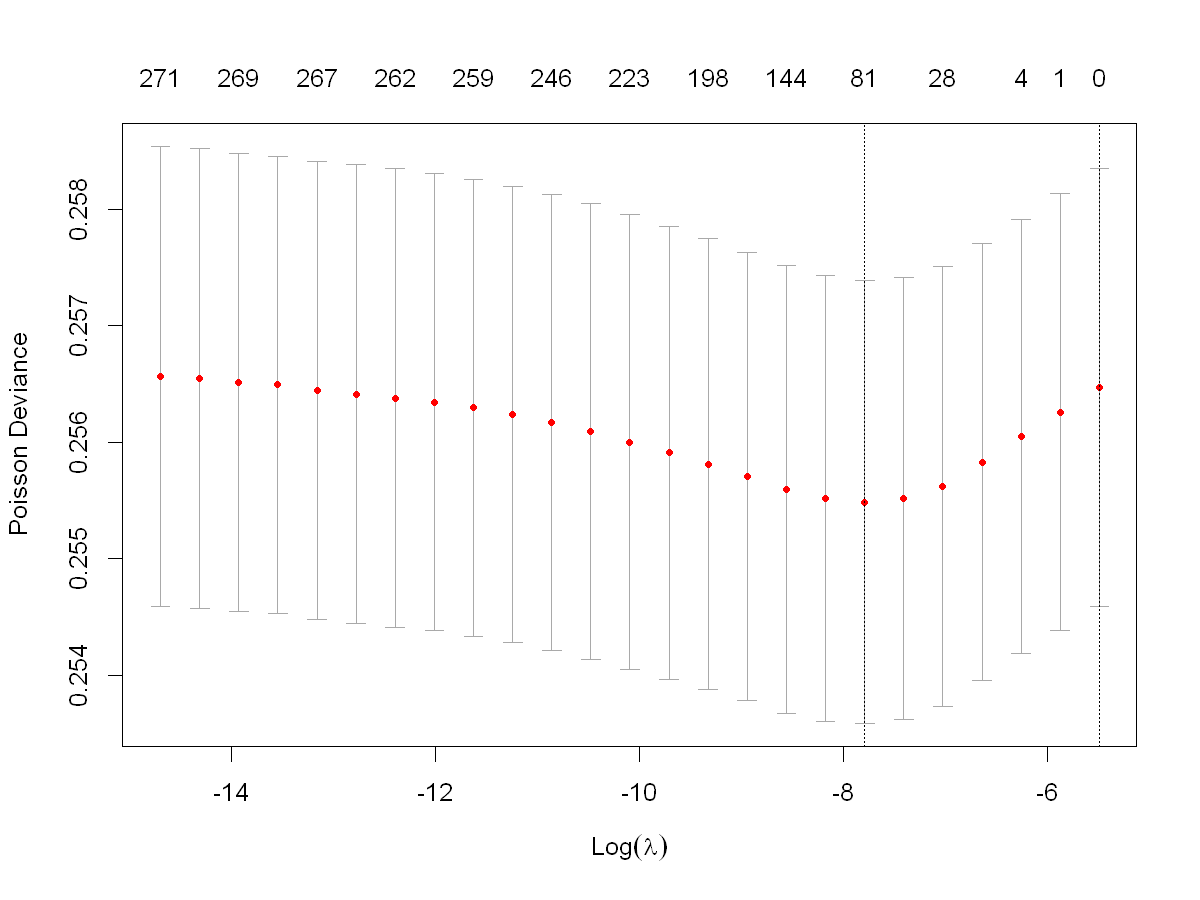

In [4]:
plot(m.lasso.0.cv)

In [5]:
coef(m.lasso.0.cv, s = "lambda.min")

274 x 1 sparse Matrix of class "dgCMatrix"
                                                                            s1
(Intercept)                                                      -2.5394767393
Powerd                                                           -0.1033242799
Powere                                                            .           
Powerf                                                            .           
Powerg                                                            .           
Powerh                                                            .           
Poweri                                                            .           
Powerj                                                            .           
Powerk                                                            .           
Powerl                                                            .           
Powerm                                                            .           
Powern   

# Ridge

In [6]:
ptn=Sys.time()
set.seed(58)
m.ridge.0.cv = cv.glmnet(x, y = training_set$ClaimNb, offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 0, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit = 10^3,
       nlambda = 25)

ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 3.911894 mins

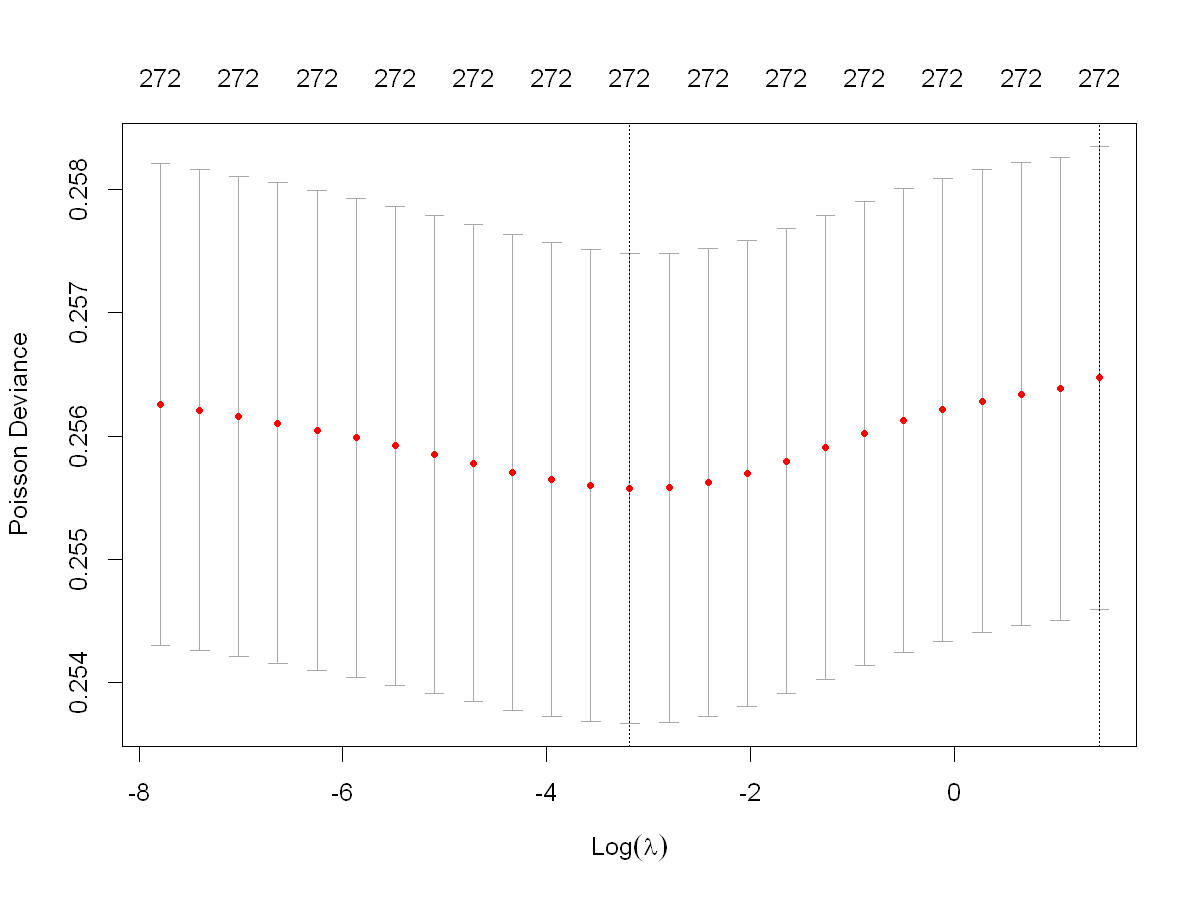

In [7]:
plot(m.ridge.0.cv)

# Elastic Net

In [ ]:
ptn=Sys.time()
set.seed(58)
m.elasticnet.0.cv = cv.glmnet(x, y = training_set$ClaimNb, offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 0.5, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit = 10^3,
       nlambda = 25)

ptn_1 = Sys.time() - ptn
ptn_1

In [ ]:
plot(m.elasticnet.0.cv)

# Comparison with GLM

In [ ]:
x_test = model.matrix(ClaimNb ~ 0 + Power * Region + Power * Brand + Power * Gas +
    Region * Brand + Region * Gas + Brand * Gas, data = testing_set)


2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.lasso.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.lasso.0.cv$lambda.min, type = "response"),
        log = TRUE)))

In [ ]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.ridge.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.ridge.0.cv$lambda.min, type = "response"),
        log = TRUE)))

In [ ]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.elasticnet.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.elasticnet.0.cv$lambda.min,
        type = "response"), log = TRUE)))

# Experiment

Let us construct the factors a bit differently. We will only use the variables DriverAge and CarAge for illustration here.

In [ ]:
for (age in (18:99)){
    training_set[paste0("DriverAge_", age)] = 1*(training_set$DriverAge <= age)
    testing_set[paste0("DriverAge_", age)] = 1*(testing_set$DriverAge <= age)
}

for (vehage in (0:25)){
    training_set[paste0("CarAge_", vehage)] = 1*(training_set$CarAge <= vehage)
    testing_set[paste0("CarAge_", vehage)] = 1*(testing_set$CarAge <= vehage)
}


In [ ]:
ptn=Sys.time()
model_exp_x = model.matrix(ClaimNb ~ 0 + DriverAge_18 + DriverAge_19 + DriverAge_20 + DriverAge_21 + DriverAge_22 + 
                 DriverAge_23 + DriverAge_24 + DriverAge_25 + DriverAge_26 + DriverAge_27 + DriverAge_28 + 
                 DriverAge_29 + DriverAge_30 + DriverAge_31 + DriverAge_32 + DriverAge_33 + DriverAge_34 + 
                 DriverAge_35 + DriverAge_36 + DriverAge_37 + DriverAge_38 + DriverAge_39 + DriverAge_40 + 
                 DriverAge_41 + DriverAge_42 + DriverAge_43 + DriverAge_44 + DriverAge_45 + DriverAge_46 + 
                 DriverAge_47 + DriverAge_48 + DriverAge_49 + DriverAge_50 + DriverAge_51 + DriverAge_52 + 
                 DriverAge_53 + DriverAge_54 + DriverAge_55 + DriverAge_56 + DriverAge_57 + DriverAge_58 + 
                 DriverAge_59 + DriverAge_60 + DriverAge_61 + DriverAge_62 + DriverAge_63 + DriverAge_64 + 
                 DriverAge_65 + DriverAge_66 + DriverAge_67 + DriverAge_68 + DriverAge_69 + DriverAge_70 + 
                 DriverAge_71 + DriverAge_72 + DriverAge_73 + DriverAge_74 + DriverAge_75 + DriverAge_76 + 
                 DriverAge_77 + DriverAge_78 + DriverAge_79 + DriverAge_80 + DriverAge_81 + DriverAge_82 + 
                 DriverAge_83 + DriverAge_84 + DriverAge_85 + DriverAge_86 + DriverAge_87 + DriverAge_88 + 
                 DriverAge_89 + DriverAge_90 + DriverAge_91 + DriverAge_92 + DriverAge_93 + DriverAge_94 + 
                 DriverAge_95 + DriverAge_96 + DriverAge_97 + DriverAge_98 + DriverAge_99 + 
                 CarAge_0 + CarAge_1 + CarAge_2 + CarAge_3 + CarAge_4 + CarAge_5 + CarAge_6 + 
                 CarAge_7 + CarAge_8 + CarAge_9 + CarAge_10 + CarAge_11 + CarAge_12 + 
                 CarAge_13 + CarAge_14 + CarAge_15 + CarAge_16 + CarAge_17 + CarAge_18 + 
                 CarAge_19 + CarAge_20 + CarAge_21 + CarAge_22 + CarAge_23 + CarAge_24 + CarAge_25,
                 data=training_set)


In [ ]:
set.seed(542)
folds = createFolds(training_set$ClaimNb, 5, list=FALSE)

set.seed(58)
m.lasso.1.cv = cv.glmnet(  model_exp_x, y = training_set$ClaimNb, 
                           offset = log(training_set$Exposure),
                           family = "poisson",
                           alpha = 1, #LASSO = 1, Ridge = 0,
                           nfolds = 5,
                           foldid = folds,
                           maxit=10^4,
                           nlambda = 25)


ptn_1 = Sys.time() - ptn
ptn_1

In [ ]:
m.lasso.1.cv

In [ ]:
coef(m.lasso.1.cv, s = "lambda.min")

In [ ]:
plotdata = expand.grid(DriverAge = 18:99, CarAge = 0:25, Exposure = 1)


for (age in (18:99)){
    plotdata[paste0("DriverAge_", age)] = 1*(plotdata$DriverAge <= age)
}
for (vehage in (0:25)){
    plotdata[paste0("CarAge_", vehage)] = 1*(plotdata$CarAge <= vehage)
}

plotdata['prediction'] = predict(m.lasso.1.cv, 
                                 as.matrix(subset(plotdata, select = -c(DriverAge, CarAge, Exposure))),
                                 newoffset = 0, 
                                 type="response", 
                                 s = m.lasso.1.cv$lambda.min)


In [ ]:
require(ggplot2)
ggplot(plotdata %>% group_by(DriverAge) %>% summarise(prediction = mean(prediction)), 
       aes(x=DriverAge, y=prediction)) + geom_point() + geom_line() + theme_bw()

In [ ]:
ggplot(plotdata %>% group_by(CarAge) %>% summarise(prediction = mean(prediction)), 
       aes(x=CarAge, y=prediction)) + geom_point() + geom_line() + theme_bw()